In [1]:
import sys
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/__github/monomolecular_reduction/')
print(sys.path)

['/mnt/c/Datas/ModelReduction/LNetReduce', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/__github/monomolecular_reduction/']


In [12]:
import networkx as nx
from lnetreduce import reduction
from lnetreduce import simulation
import numpy as np
import matplotlib.pyplot as plt


def get_edge_labels_dic(G):
    edge_labels = {}
    for e in G.edges:
        edge_labels[e] = G.get_edge_data(e[0],e[1])['weight']    
    return edge_labels

def permute_timescales(G):
    edge_labels = get_edge_labels_dic(G)
    vals = list(edge_labels.values())
    perm = np.random.permutation(len(vals))
    for i,e in enumerate(edge_labels):
        edge_labels[e] = vals[perm[i]]
    nx.set_edge_attributes(G,edge_labels,'weight')
    
def plot_dynamics(G,title='',timescale=5,highlighted_node=None):
    X = np.zeros((len(G.edges),3)).astype(np.int32)
    node_names = []
    for n in G:
        node_names.append(n)
    node_names.sort()
    for i,e  in enumerate(G.edges):
        X[i,0] = node_names.index(e[0])
        X[i,1] = node_names.index(e[1])
        X[i,2] = G.get_edge_data(e[0],e[1])['weight']
    (t,XX,_) = simulation.simulate(X.T, timescale)
    simulation.plot_trace(XX,logy=False,logx=True,labels=node_names,time=t)
    #simulation.plot_trace(XX,logy=False,logx=True,time=t)
    if not highlighted_node is None:
        irx = node_names.index(highlighted_node)
        plt.plot(t,XX[:,irx],'r-',linewidth=5)
    plt.title(title)

### We load the file containing the model from https://link.springer.com/chapter/10.1007/978-3-030-60327-4_3#Fig2
![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-60327-4_3/MediaObjects/496159_1_En_3_Fig2_HTML.png)

#### With the $\epsilon$ orders provided in the paper, the reduction algorithm ends up with a cycle containing two kinetic rates of the same order 0, which formally leads to error message. To avoid this, we modify the reaction rate S2->S1 to the order -3. This won't change the conclusion about emergence of slow time scales not initially present in the initial reaction rates

{('S1', 'S2'): -1, ('S2', 'S1'): -3, ('S2', 'S3'): -1, ('S3', 'S2'): -1, ('S3', 'S4'): -2, ('S4', 'S3'): -1}


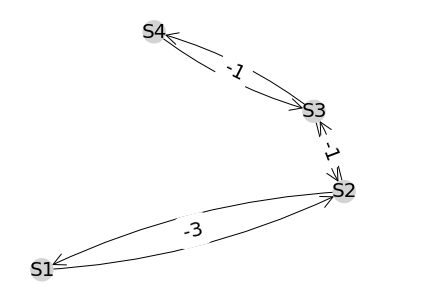

In [5]:
# load the model
filename = 'models/petrov1.csv'
reduced_filename = "%s_reduced" % filename
timescale = 5
G = reduction.load(filename)

# prepare some stuff for visualization
node_names = []
for n in G:
    node_names.append(n)
color_map = []
for node in G:
    color_map.append('lightgray')

# compute the layout
pos = nx.nx_pydot.graphviz_layout(G)

# draw the graph
nx.draw(G, pos,with_labels = True,node_color=color_map,
        font_size=20,node_size=500,arrowsize=30,arrowstyle='->',
       connectionstyle="arc3,rad=0.1")
edge_labels = get_edge_labels_dic(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='black',font_size=20)

# show the edge labels (difficult to show on reciprocal arrows)
edge_labels = get_edge_labels_dic(G)
print(edge_labels)
plt.show()


### Now we reduce the model and show the resulting orders of kinetic rates
### One can notice that there is a reaction S4->S2 of order 0, slower than any initial reaction rate

ungluing: {'S1': OutEdgeDataView([('S4', 'S1', 0), ('S1', 'S4', 1)])}
    S1 (lim:S1)   [('S4', 'S1', 0)]
    Restore incoming edges [] []
    Ready to unglue: ['S1'] [('S4', 'S1', 0)]
ungluing: {'S4': OutEdgeDataView([('S3', 'S4', -2), ('S4', 'S3', -1)]), 'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S4 (lim:S4)   [('S3', 'S4', -2)]
    Restore incoming edges [] [('S2', 'S3', -1)]
    S1 (lim:S1)   [('S3', 'S4', -2), ('S2', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', 0)] [('S4', 'S2', 0)]
    Ready to unglue: ['S4', 'S1'] [('S3', 'S4', -2), ('S2', 'S1', -3), ('S4', 'S2', 0)]


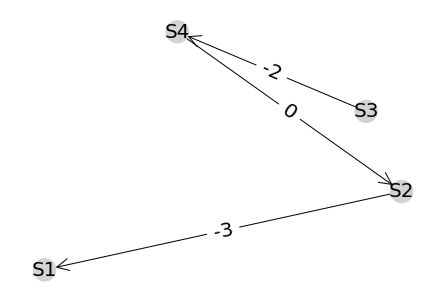

In [6]:
try:
    uG = reduction.reduce_graph(G)
    reduction.save_graph(uG, reduced_filename)
    nx.draw(uG, pos, with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
    edge_labels = get_edge_labels_dic(uG)
    nx.draw_networkx_edge_labels(uG,pos,edge_labels=edge_labels,font_color='black',font_size=20)
    plt.show()
except:
    print('ERROR: Error in reduction!')

### Now let us investigate many different distribution of kinetic orders in this example
### We will test $N=3^6=729$ possible combinations of kinetic orders $-1,-2,-3$ on each reaction

In [7]:
from itertools import product

edge_labels = get_edge_labels_dic(G)
orders = list(product([-1,-2,-3],repeat = len(edge_labels)))
graphs = []
for p in orders:
    for i,e in enumerate(edge_labels):
        edge_labels[e] = p[i]
    G1 = G.copy()
    nx.set_edge_attributes(G1,edge_labels,'weight')
    graphs.append(G1)
print(len(graphs),' graphs generated.')

729  graphs generated.


#### Here we reduce all the graphs and find that in 80% of cases we can not apply the complete reduction algorithm, that there are 3 graphs with slow transients, and there are 9 unique up to isomorphism reduced graphs

In [8]:
# generate a list of unique up to isomorphism reduced graphs
# we also seek for the appearance of super-slow timescales, not initially present in the system

def nm(n1,n2):
    if n1['id']==n2['id']:
        return True
    else:
        return False
    
def get_max_timescale(G):
    max_time_scale = -np.inf
    for e in G.edges:
        weight = G.get_edge_data(e[0],e[1])['weight']
        if weight>max_time_scale:
            max_time_scale = weight
    return max_time_scale

max_timescale = get_max_timescale(G)
print('Maximum timescale=',max_timescale)
    
slow_graphs = []
slow_timescales = []
unique_reduced = []
counts = []
count_errors = 0
for gr in graphs:
    try:
        ugr = reduction.reduce_graph(gr)
        mx_ts = get_max_timescale(ugr)
        if mx_ts>max_timescale:
            slow_graphs.append(gr)
            slow_timescales.append(mx_ts)
        node_ids = {}
        for n in ugr.nodes:
            node_ids[n] = n
        nx.set_node_attributes(ugr,node_ids,'id')    
        found = False
        for i,red_gr in enumerate(unique_reduced):
            node_ids = {}
            for n in red_gr.nodes:
                node_ids[n] = n
            nx.set_node_attributes(red_gr,node_ids,'id')
            if nx.is_isomorphic(ugr,red_gr,node_match=nm):
            #if nx.is_isomorphic(ugr,red_gr):
                found = True
                counts[i] = counts[i]+1
        if not found:
            unique_reduced.append(ugr)
            counts.append(1)
    except:
        count_errors+=1
print('Fraction of reduction errors=',count_errors/len(graphs))
print('Unique graphs=',len(unique_reduced))
print('Distribution of unique graphs freqs=',counts)
total_counts = 0
for c in counts:
    total_counts+=c
print('Slow graphs=',len(slow_graphs))
print('Slow timescales=',slow_timescales)

Maximum timescale= -1
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
Duplicated best edge
ungluing: {'S4': OutEdgeDataView([('S2', 'S4', -2), ('S4', 'S2', 0)])}
    S4 (lim:S4)   [('S2', 'S4', -2)]
    Restore incoming edges [('S1', 'S4', -1)] [('S1', 'S2', -1)]
    Ready to unglue: ['S4'] [('S2', 'S4', -2), ('S1', 'S2', -1)]
ungluing: {'S4': OutEdgeDataView([('S3', 'S4', -2), ('S4', 'S3', -1)])}
    S4 (lim:S4)   [('S3', 'S4', -2)]
 

ungluing: {'S1': OutEdgeDataView([('S3', 'S1', -3), ('S1', 'S3', 0)])}
    S1 (lim:S1)   [('S3', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', -3)] [('S4', 'S3', -3)]
    Ready to unglue: ['S1'] [('S3', 'S1', -3), ('S4', 'S3', -3)]
ungluing: {'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S1 (lim:S1)   [('S2', 'S1', -3)]
    Restore incoming edges [('S3', 'S1', -3)] [('S3', 'S2', -3)]
    Ready to unglue: ['S1'] [('S2', 'S1', -3), ('S3', 'S2', -3)]
ungluing: {'S1': OutEdgeDataView([('S3', 'S1', -3), ('S1', 'S3', 0)])}
    S1 (lim:S1)   [('S3', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', -1)] [('S4', 'S3', -1)]
    Ready to unglue: ['S1'] [('S3', 'S1', -3), ('S4', 'S3', -1)]
ungluing: {'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S1 (lim:S1)   [('S2', 'S1', -3)]
    Restore incoming edges [('S3', 'S1', -3)] [('S3', 'S2', -3)]
    Ready to unglue: ['S1'] [('S2', 'S1', -3), ('S3', 'S2', -3)]
ungluing: {'S1': OutEdgeDataView([('S3', 'S1',

    S4 (lim:S4)   [('S3', 'S4', -3)]
    Restore incoming edges [('S1', 'S4', -1)] [('S2', 'S3', -2)]
    S1 (lim:S1)   [('S3', 'S4', -3), ('S2', 'S1', -3)]
    Restore incoming edges [] [('S4', 'S2', 0)]
    Ready to unglue: ['S4', 'S1'] [('S3', 'S4', -3), ('S2', 'S1', -3)]
Duplicated best edge
ungluing: {'S1': OutEdgeDataView([('S3', 'S1', -2), ('S1', 'S3', -1)])}
    S1 (lim:S1)   [('S3', 'S1', -2)]
    Restore incoming edges [('S4', 'S1', -1)] [('S4', 'S3', -1)]
    Ready to unglue: ['S1'] [('S3', 'S1', -2), ('S4', 'S3', -1)]
ungluing: {'S1': OutEdgeDataView([('S1', 'S2', -2), ('S2', 'S1', -3)])}
    S1 (lim:S1)   [('S2', 'S1', -3)]
    Restore incoming edges [('S3', 'S1', -2)] [('S3', 'S2', -2)]
    Ready to unglue: ['S1'] [('S2', 'S1', -3), ('S3', 'S2', -2)]
ungluing: {'S1': OutEdgeDataView([('S3', 'S1', -2), ('S1', 'S3', -1)])}
    S1 (lim:S1)   [('S3', 'S1', -2)]
    Restore incoming edges [('S4', 'S1', -2)] [('S4', 'S3', -2)]
    Ready to unglue: ['S1'] [('S3', 'S1', -2), ('S4

Number of slow graphs =  3
('S1', 'S2') -1
('S2', 'S1') -3
('S2', 'S3') -1
('S3', 'S2') -1
('S3', 'S4') -2
('S4', 'S3') -1
ungluing: {'S1': OutEdgeDataView([('S4', 'S1', 0), ('S1', 'S4', 1)])}
    S1 (lim:S1)   [('S4', 'S1', 0)]
    Restore incoming edges [] []
    Ready to unglue: ['S1'] [('S4', 'S1', 0)]
ungluing: {'S4': OutEdgeDataView([('S3', 'S4', -2), ('S4', 'S3', -1)]), 'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S4 (lim:S4)   [('S3', 'S4', -2)]
    Restore incoming edges [] [('S2', 'S3', -1)]
    S1 (lim:S1)   [('S3', 'S4', -2), ('S2', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', 0)] [('S4', 'S2', 0)]
    Ready to unglue: ['S4', 'S1'] [('S3', 'S4', -2), ('S2', 'S1', -3), ('S4', 'S2', 0)]


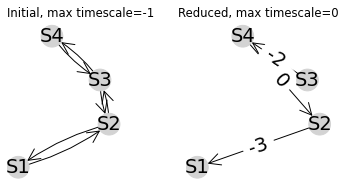

('S1', 'S2') -1
('S2', 'S1') -3
('S2', 'S3') -1
('S3', 'S2') -1
('S3', 'S4') -3
('S4', 'S3') -2
ungluing: {'S1': OutEdgeDataView([('S4', 'S1', 0), ('S1', 'S4', 1)])}
    S1 (lim:S1)   [('S4', 'S1', 0)]
    Restore incoming edges [] []
    Ready to unglue: ['S1'] [('S4', 'S1', 0)]
ungluing: {'S4': OutEdgeDataView([('S3', 'S4', -3), ('S4', 'S3', -2)]), 'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S4 (lim:S4)   [('S3', 'S4', -3)]
    Restore incoming edges [] [('S2', 'S3', -1)]
    S1 (lim:S1)   [('S3', 'S4', -3), ('S2', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', 0)] [('S4', 'S2', 0)]
    Ready to unglue: ['S4', 'S1'] [('S3', 'S4', -3), ('S2', 'S1', -3), ('S4', 'S2', 0)]


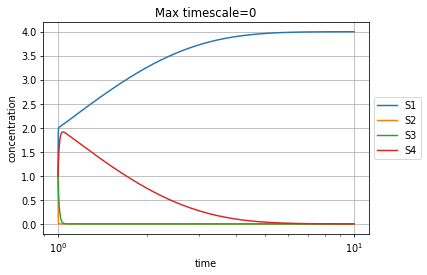

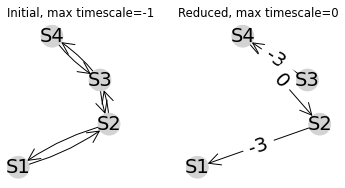

('S1', 'S2') -1
('S2', 'S1') -3
('S2', 'S3') -1
('S3', 'S2') -2
('S3', 'S4') -3
('S4', 'S3') -1
ungluing: {'S1': OutEdgeDataView([('S4', 'S1', 0), ('S1', 'S4', 1)])}
    S1 (lim:S1)   [('S4', 'S1', 0)]
    Restore incoming edges [] []
    Ready to unglue: ['S1'] [('S4', 'S1', 0)]
ungluing: {'S4': OutEdgeDataView([('S3', 'S4', -3), ('S4', 'S3', -1)]), 'S1': OutEdgeDataView([('S1', 'S2', -1), ('S2', 'S1', -3)])}
    S4 (lim:S4)   [('S3', 'S4', -3)]
    Restore incoming edges [] [('S2', 'S3', -1)]
    S1 (lim:S1)   [('S3', 'S4', -3), ('S2', 'S1', -3)]
    Restore incoming edges [('S4', 'S1', 0)] [('S4', 'S2', 0)]
    Ready to unglue: ['S4', 'S1'] [('S3', 'S4', -3), ('S2', 'S1', -3), ('S4', 'S2', 0)]


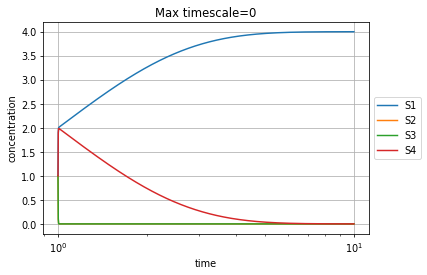

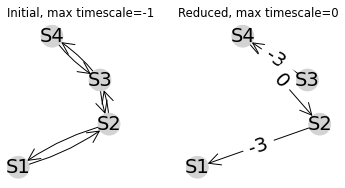

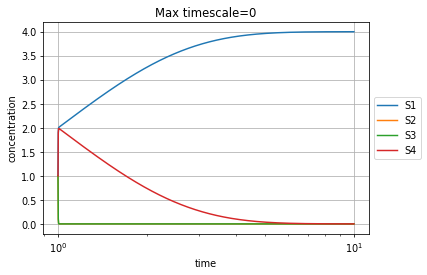

In [17]:
# draw slow graphs
plt.rcParams['figure.dpi']= 70
print('Number of slow graphs = ',len(slow_graphs))

max_number_of_graphs = 5
most_slow = True
if most_slow:
    irx = np.argsort(-np.array(slow_timescales))
else:
    irx = np.argsort(np.array(slow_timescales))
    
do_plot_dynamics = True
    
timescale=1

k = 0
for i in irx:
    plt.figure(figsize=(6.0,3.0))
    plt.subplot(1,2,1)
    ugr = slow_graphs[i]
    color_map = []
    for n in ugr:
        color_map.append('lightgray')
    nx.draw(ugr, pos, with_labels = True,node_color=color_map,
            font_size=20,node_size=500,arrowsize=30,
            arrowstyle='->',connectionstyle="arc3,rad=0.1")
    edge_labels = get_edge_labels_dic(ugr)
    #nx.draw_networkx_edge_labels(ugr,pos,edge_labels=edge_labels,font_color='black',font_size=20)
    for e in ugr.edges:
        print(e,edge_labels[e])
    plt.title('Initial, max timescale='+str(get_max_timescale(ugr)))
    plt.subplot(1,2,2)
    ugr = reduction.reduce_graph(ugr)
    color_map = []
    for n in ugr:
        color_map.append('lightgray')
    nx.draw(ugr, pos, with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
    edge_labels = get_edge_labels_dic(ugr)
    nx.draw_networkx_edge_labels(ugr,pos,edge_labels=edge_labels,font_color='black',font_size=20)
    plt.title('Reduced, max timescale='+str(slow_timescales[i]))    
    plt.show()
    
    if do_plot_dynamics:
        plot_dynamics(ugr,title='Max timescale='+str(slow_timescales[i]),timescale=timescale)
    k+=1
    if k>max_number_of_graphs:
        break

Number of unique graphs =  6


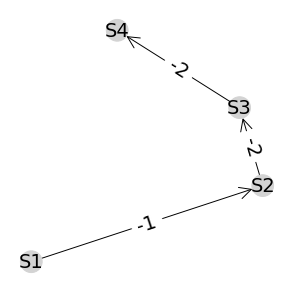

Frequency= 0.34507042253521125


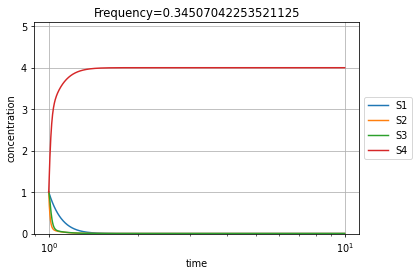

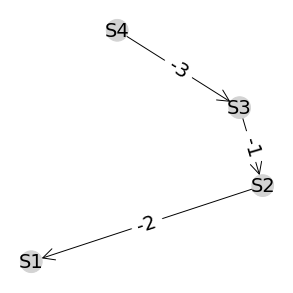

Frequency= 0.34507042253521125


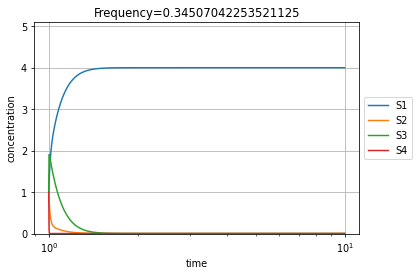

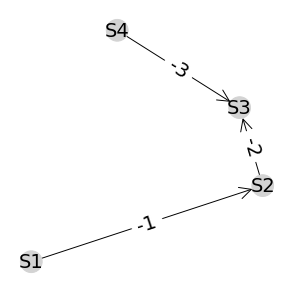

Frequency= 0.1056338028169014


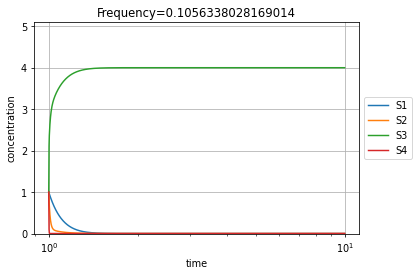

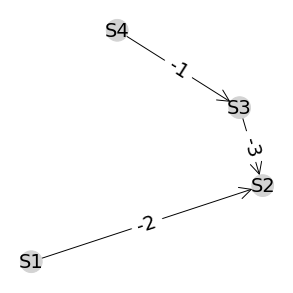

Frequency= 0.1056338028169014


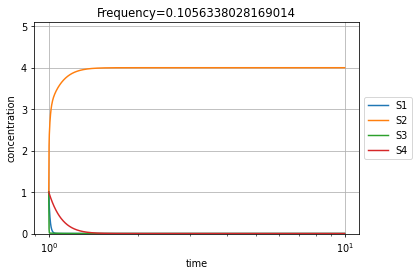

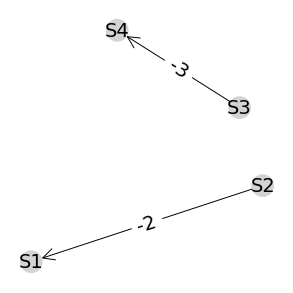

Frequency= 0.04929577464788732


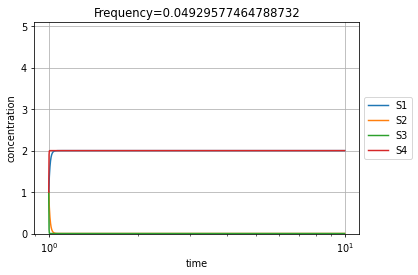

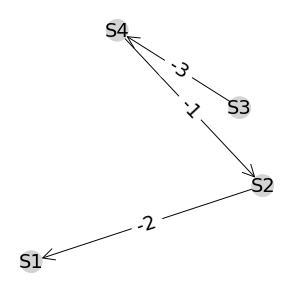

Frequency= 0.04929577464788732


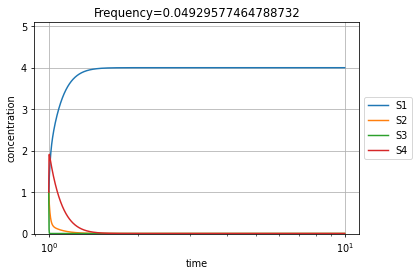

In [21]:
# draw unique graphs
plt.rcParams['figure.dpi']= 70
print('Number of unique graphs = ',len(unique_reduced))


max_number_of_graphs = 20
most_frequent = True
if most_frequent:
    irx = np.argsort(-np.array(counts))
else:
    irx = np.argsort(np.array(counts))
    
do_plot_dynamics = True
    
timescale=1

k = 0
for i in irx:
    ugr = unique_reduced[i]
    plt.figure(figsize=(4,4))
    color_map = []
    for n in ugr:
        color_map.append('lightgray')
    nx.draw(ugr, pos, with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
    edge_labels = get_edge_labels_dic(ugr)
    nx.draw_networkx_edge_labels(ugr,pos,edge_labels=edge_labels,font_color='black',font_size=20)
    plt.show()
    print('Frequency=',counts[i]/total_counts)
    if do_plot_dynamics:
        #plot_dynamics(ugr,title='Frequency='+str(counts[i]/total_counts),timescale=timescale,highlighted_node='MYCN')
        plot_dynamics(ugr,title='Frequency='+str(counts[i]/total_counts),timescale=timescale)
        plt.ylim([0,5.1])
        plt.show()
    k+=1
    if k>max_number_of_graphs:
        break